# Import libraries and data

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import io

from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [2]:
# Uploading to Google colab
from google.colab import files
uploaded = files.upload()

Saving X_real_test_model.csv to X_real_test_model.csv
Saving X_test_model.csv to X_test_model.csv
Saving X_train_model.csv to X_train_model.csv
Saving y_test_model.csv to y_test_model.csv
Saving y_train_model.csv to y_train_model.csv


In [84]:
# Opening the files

X_train = pd.read_csv(io.BytesIO(uploaded['X_train_model.csv']), sep=',')
X_test = pd.read_csv(io.BytesIO(uploaded['X_test_model.csv']), sep=',')
X_real_test = pd.read_csv(io.BytesIO(uploaded['X_real_test_model.csv']), sep=',')
y_train = pd.read_csv(io.BytesIO(uploaded['y_train_model.csv']), sep=',')
y_test = pd.read_csv(io.BytesIO(uploaded['y_test_model.csv']), sep=',')


In [85]:
X_train = X_train.drop(columns='ID')
X_test = X_test.drop(columns = 'ID')
X_real_test1 = X_real_test.drop(columns = 'ID')

In [86]:
X_train.shape, X_test.shape, X_real_test1.shape

((3375, 64), (1125, 64), (4680, 64))

#### Neural Network

In [87]:
model = Sequential()

model.add(Input((64,)))

#add a hidden layer
model.add(Dense(64, activation = 'relu'))

#add a dropout
model.add(Dropout(0.3))

#add a hidden layer
model.add(Dense(15, activation = 'relu'))

#Final layer with 1 output, activation could be none and default is linear
model.add(Dense(1, activation = 'linear'))

In [88]:
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['RootMeanSquaredError'])

In [89]:
early_stop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 5, # (it is going to stop improving after 5 tries without improvement
    restore_best_weights = True #if patience is surpassed
)

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, verbose = 0)


In [90]:
# To review the last mean squared error of the epochs
history.history['val_root_mean_squared_error'][-1]

2743.95166015625

It can be observed that the test set diverges. We try regularizing to avoid that overfitting.

Furthermore, the Root Mean Squared Error in test was 2743.95, which is much more higher than any other model we tested before

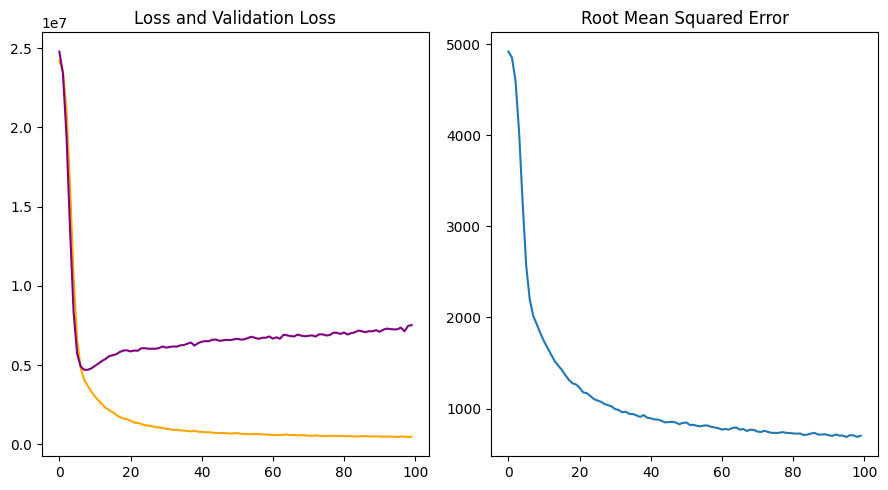

In [91]:
plt.figure(figsize = (9 , 5))

# (1, 2, 1) means we have 1 rows, 2 column, and are referencing plot 1.
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history.history['loss'], label = 'train loss', color = 'orange')
ax1.plot(history.history['val_loss'], label = 'val loss', color = 'purple')
ax1.set_title("Loss and Validation Loss")


# (1, 2, 2) means we have 1 rows, 2 column, and are referencing plot 2.
ax2 = plt.subplot(1, 2, 2, sharex=ax1)
ax2.plot(history.history['root_mean_squared_error'], label = 'root mean squared error')
ax2.set_title("Root Mean Squared Error")

plt.tight_layout(); # adds more space

#### To avoid the overfitting and the divergence of train and test loss, we try a regularized neural network

In [92]:
model_l2 = Sequential()

model_l2.add(Input((64,)))

#add a hidden layer
model_l2.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.1)))

#add a dropout
model_l2.add(Dropout(0.3))

#add a hidden layer
model_l2.add(Dense(32, activation = 'relu', kernel_regularizer = l2(0.1)))

#add a dropout
model_l2.add(Dropout(0.3))

#add a hidden layer
model_l2.add(Dense(16, activation = 'relu', kernel_regularizer = l2(0.1)))

#Final layer with 1 output, activation could be none and default is linear
model_l2.add(Dense(1, activation = 'linear'))

In [93]:
model_l2.compile(loss = 'mse', optimizer = 'adam', metrics = ['RootMeanSquaredError'])

In [94]:
early_stop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 5, # (it is going to stop improving after 5 tries without improvement
    restore_best_weights = True #if patience is surpassed
)

history2 = model_l2.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, verbose = 0)



In [95]:
# To review the last mean squared error of the epochs
history2.history['val_root_mean_squared_error'][-1]

2940.2578125

We created a complex Neural Network with Dropout and regularization, however, the results of the Root Mean Squared Error = 2940.25 are not better than the Random Forest Regressor (216.97) from the 4.1_Modeling notebook.

This neural network creates an overfitted model as it goes learning from the train data.

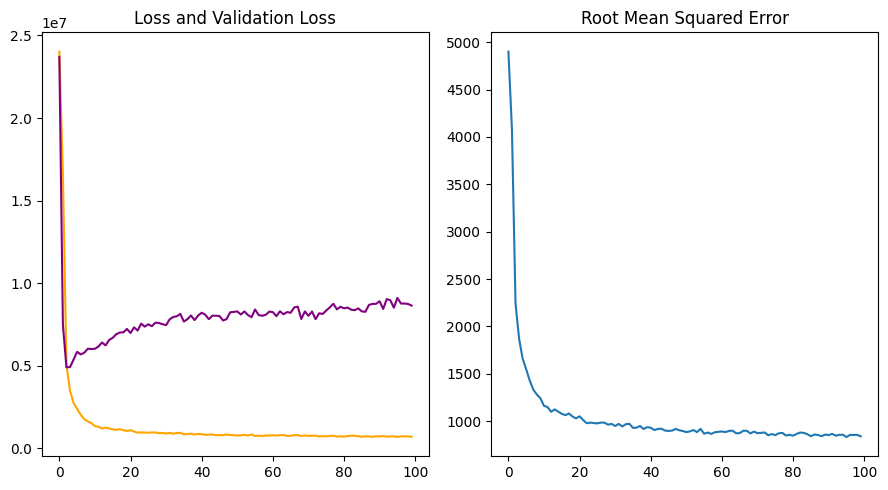

In [96]:
plt.figure(figsize = (9 , 5))

# (1, 2, 1) means we have 1 rows, 2 column, and are referencing plot 1.
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history2.history['loss'], label = 'train loss', color = 'orange')
ax1.plot(history2.history['val_loss'], label = 'val loss', color = 'purple')
ax1.set_title("Loss and Validation Loss")


# (1, 2, 2) means we have 1 rows, 2 column, and are referencing plot 2.
ax2 = plt.subplot(1, 2, 2, sharex=ax1)
ax2.plot(history2.history['root_mean_squared_error'], label = 'root mean squared error')
ax2.set_title("Root Mean Squared Error")

plt.tight_layout(); # adds more space

In [97]:
model_l2.predict(X_real_test1)

147/147 [==============================] - 0s 2ms/step


array([[4009.2805],
       [4085.235 ],
       [3933.143 ],
       ...,
       [6950.015 ],
       [6072.3496],
       [5183.351 ]], dtype=float32)

In [54]:
# Create data frame for Kaggle submission
kaggle_5A = pd.DataFrame(model_l2.predict(X_real_test1), columns = ['Incidence'])
kaggle_5A['ID'] = X_real_test['ID']

#Saving to csv to submit
kaggle_5A.to_csv('kaggle_5A.csv', sep=',', index = False)

147/147 [==============================] - 0s 2ms/step


Since future predictions should be based in Year we try one last model without Year, to see if we can create a good prediction based only on the pollutants and the lagged variables

In [98]:
X_train = X_train.drop(columns='Year')
X_test = X_test.drop(columns = 'Year')
X_real_test1 = X_real_test1.drop(columns = 'Year')

In [59]:
model_l2_noYear = Sequential()

model_l2_noYear.add(Input((63,)))

#add a hidden layer
model_l2_noYear.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.1)))

#add a dropout
model_l2_noYear.add(Dropout(0.3))

#add a hidden layer
model_l2_noYear.add(Dense(32, activation = 'relu', kernel_regularizer = l2(0.1)))

#add a dropout
model_l2_noYear.add(Dropout(0.3))

#add a hidden layer
model_l2_noYear.add(Dense(16, activation = 'relu', kernel_regularizer = l2(0.1)))

#Final layer with 1 output, activation could be none and default is linear
model_l2_noYear.add(Dense(1, activation = 'linear'))

In [60]:
model_l2_noYear.compile(loss = 'mse', optimizer = 'adam', metrics = ['RootMeanSquaredError'])

In [63]:
early_stop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 5, # (it is going to stop improving after 5 tries without improvement
    restore_best_weights = True #if patience is surpassed
)

history3 = model_l2_noYear.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 500, verbose = 0)

In [82]:
history3.history['val_root_mean_squared_error'][-1]

1153.2794189453125

The complex Neural Network without Year with 500 epochs is less overfit. In the graph we can see that loss of train and test would seem to converge a little. However the convergence plateaus.

The Root Mean Squared Error is better than with the previous Neural Networks, but still higher than with Random Forest Regresor (216.97) from the 4.1_Modeling notebook.

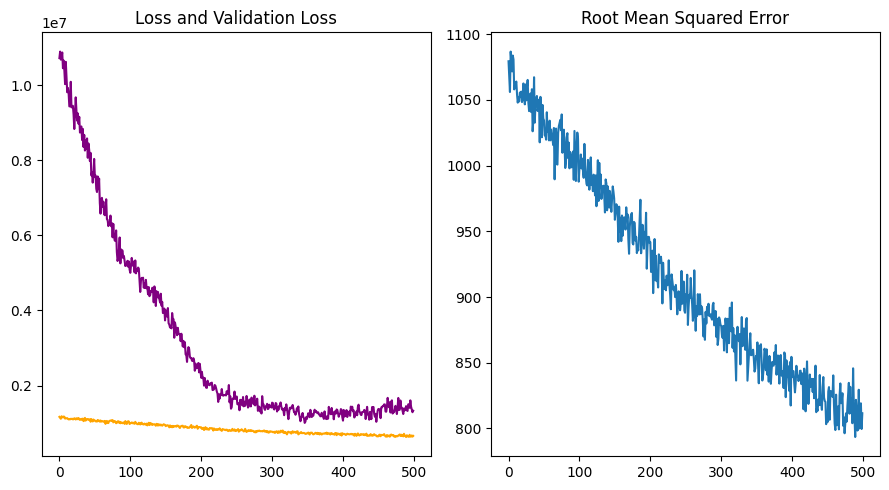

In [64]:
plt.figure(figsize = (9 , 5))

# (1, 2, 1) means we have 1 rows, 2 column, and are referencing plot 1.
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history3.history['loss'], label = 'train loss', color = 'orange')
ax1.plot(history3.history['val_loss'], label = 'val loss', color = 'purple')
ax1.set_title("Loss and Validation Loss")


# (1, 2, 2) means we have 1 rows, 2 column, and are referencing plot 2.
ax2 = plt.subplot(1, 2, 2, sharex=ax1)
ax2.plot(history3.history['root_mean_squared_error'], label = 'root mean squared error')
ax2.set_title("Root Mean Squared Error")

plt.tight_layout(); # adds more space

In [74]:
# Create data frame for Kaggle submission
kaggle_6A = pd.DataFrame(model_l2_noYear.predict(X_real_test1), columns = ['Incidence'])
kaggle_6A['ID'] = X_real_test['ID']

#Saving to csv to submit
kaggle_6A.to_csv('kaggle_6A.csv', sep=',', index = False)

147/147 [==============================] - 0s 2ms/step
